## Import Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip3 install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

import warnings

import numpy as np

import pickle

from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report


## Set Option

In [4]:
pd.set_option('display.max_columns', None)

warnings.filterwarnings('ignore')

## Read Data

In [7]:
df_loan = pd.read_csv("/content/drive/MyDrive/Internship Project Team/Dataset/LoanExport.csv")

## User defined function

In [8]:
# Function for replace the Not Available values to "nan"
def feature_nan(df):
  df.replace('X', np.NaN, inplace = True)
  df['CreditScore'].replace( 0, np.NaN, inplace = True)
  df['LTV'].replace( 0, np.NaN, inplace = True)
  df['Units'].replace( 0, np.NaN, inplace = True)
  return(df)

In [9]:
# Function for converting MSA feature to [1,0]
def feature_msa(df):
  df['MSA'].iloc[df['MSA'].notnull()] = 1
  df['MSA'].fillna(0, inplace = True)
  df['MSA'] = df['MSA'].astype('category')
  return(df)

In [10]:
# Function for correct the data type of features
def feature_dtype(df):
  df['MSA'] = df['MSA'].astype('object')
  df['Units'] = df['Units'].astype('object')
  df['EverDelinquent'] = df['EverDelinquent'].astype('object')
  return(df)

In [11]:
# Function for strip the column values
def feature_strip(df):
  cols = df.select_dtypes(object).columns
  df[cols] = df[cols].apply(lambda x: x.str.strip())
  return(df)

In [12]:
# Function for drop the unwanted columns
def feature_drop(df):
  df.drop(columns = ['OCLTV', 'PropertyState', 'PostalCode', 'LoanSeqNum', 'SellerName', 
                     'ServicerName', 'MonthsDelinquent', 'FirstPaymentDate', 'MaturityDate', 'ProductType'],axis = 1, inplace = True)
  return(df)

## Data Preprocessing

In [13]:
df_process = df_loan.copy()

In [14]:
df_process= feature_strip(df_process)

In [15]:
df_process = feature_nan(df_process)

In [16]:
df_process.dropna(subset = ['PropertyType', 'Units', 'LTV'], inplace = True)

In [17]:
df_process = feature_msa(df_process)

In [18]:
df_process = feature_dtype(df_process)

In [19]:
df_process = feature_drop(df_process)

## Label Encoding & Scalling

In [20]:
label_encoder = LabelEncoder()
original = df_process
mask = df_process.isnull()
df_process = df_process.astype(str).apply(label_encoder.fit_transform).where(~mask, original)

## Split dataset into Null and Non Null datasets

In [21]:
df_notnull = df_process[df_process.isnull().any(axis=1) == False] 
df_null = df_process[df_process.isnull().any(axis=1) == True]

## KNN Imputer 

In [22]:
imputer = KNNImputer()
imputer.fit(df_notnull)

KNNImputer()

In [23]:
df_imputed = imputer.fit_transform(df_null) # Take nearly 10min

In [24]:
df_processed = pd.DataFrame(df_imputed,columns = df_process.columns)
# Combine the NonNull rows and Imputed NUllvalue rows.
df_final = df_notnull.append(df_processed)

# Sort with index
df_final.sort_index(axis = 0, inplace = True)
df_final = df_final[df_final['PPM'] != 0.2]

## Model Building

In [25]:
X = df_final.drop(columns = ['PPM'], axis = 1)
y = df_final['PPM']
y = y.astype('int')

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 10)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(233129, 17) (58283, 17) (233129,) (58283,)


# Standard scalling

In [27]:
standardscale= StandardScaler()
X_train = standardscale.fit_transform(X_train)
X_test = standardscale.transform(X_test)

In [28]:
pickle.dump(standardscale, open('/content/drive/MyDrive/Internship Project Team/Final/scaler.pkl','wb'))

**Logistic Regression**

In [29]:
model= LogisticRegression(solver='newton-cg', class_weight='balanced')
model.fit(X_train,y_train)

LogisticRegression(class_weight='balanced', solver='newton-cg')

In [30]:
y_pred=model.predict(X_test)

Text(0.5, 257.44, 'Predicted label')

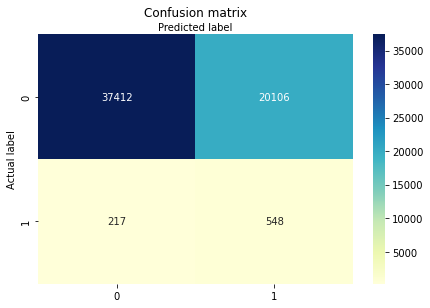

In [31]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [32]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.6513048401763808
Precision: 0.02653239082018011
Recall: 0.7163398692810458


## Pickle the model

In [33]:
# Dumping the model object to save it as model.pkl file

pickle.dump(model,open('/content/drive/MyDrive/Internship Project Team/Final/model.pkl','wb+'))